In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

Set working directory

In [3]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/'
workingDirectory = '/home/h1bennet/mpsiiia/results/02_201128_Young_CellComp/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


In [7]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_idr_fw_peaks_merged.txt')

# # try with dropped sample
# dropsamp = ['00_mouse_BL6_M_8week_PU1_ChIP_H3K27Ac_3_AL_20191226_GTAGAG_ds']

# df = df.drop(dropsamp, axis=1)
# mat = mat.drop(dropsamp, axis=1)

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

# Scatter plot of quantile normalized matrix

Get average expression

In [40]:
cells = ['PU1', 'Olig2', 'NeuN', 'Sox9']
columns = [[12,13],
           [4,5],
           [9,10,11],
           [14,15]]

avg_tags = {}

for cell, col in zip(cells, columns):
    avg_tags[cell] = mat_quant.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

In [41]:
import itertools

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


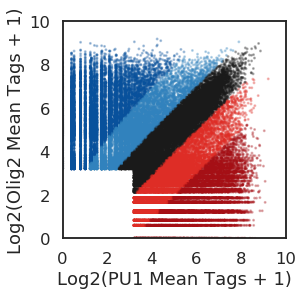

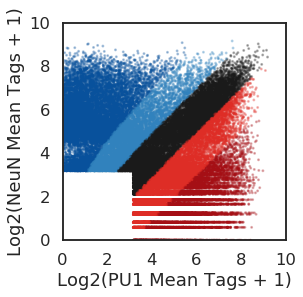

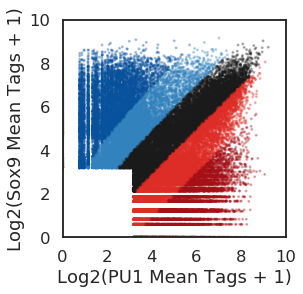

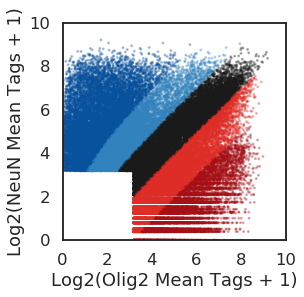

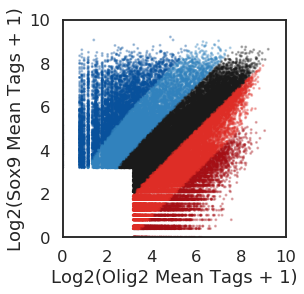

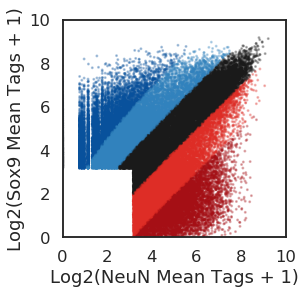

In [71]:
# set loop variables
mincount=8
thresh=[2,8]
thresh_color = {'up': ['#de2d26', '#a50f15'],
                'down': ['#3182bd', '#08519c']}
n_ticks = 5

for i, j in itertools.combinations(cells, 2):

    fig, ax = plt.subplots(figsize=(4,4))

    # filter low tag peaks
    df_tmp = avg_tags_df.loc[(avg_tags_df.loc[:, i] >= mincount) | (avg_tags_df.loc[:, j] >= mincount)]

    # set colors
    df_tmp['colors'] = 'k'
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0], 'colors'] = thresh_color['up'][0]
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0], 'colors'] = thresh_color['down'][0]
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1], 'colors'] = thresh_color['up'][1]
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1], 'colors'] = thresh_color['down'][1]

    ax.scatter(np.log2(df_tmp.loc[:, j]+1),
               np.log2(df_tmp.loc[:, i]+1),
               s=2,
               c=df_tmp.colors,
               alpha=0.3)

    # set axis limits
    countmax = np.max([np.max(np.log2(df_tmp.loc[:, j]+1)), np.max(np.log2(df_tmp.loc[:, i]+1))])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    # fix ticks
    ax.set_xticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    ax.set_yticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    
    # label axes
    ax.set_xlabel('Log2(%s Mean Tags + 1)' % i)
    ax.set_ylabel('Log2(%s Mean Tags + 1)' % j)
    